In [1]:
from IPython.display import Image, display, Math

import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator
import numpy as np
import reddemcee

np.random.seed(1234)

# Fitting a model to data
We are going to fit a simple sinusoid model, with some white noise. This model has 4 parameters, 3 for the sinusoid plus the jitter related to the white noise:

In [2]:
# True parameters
K_ = 55
P_ = 4.1

j_ = 5  # white noise
ndim_ = 3

theta_ = [K_, P_, j_]

# We generate the observation time stamps
N_ = 100
baseline = 6
x_ = np.sort(np.random.uniform(0, baseline, N_))

# And their values
# Sinusoid
def sinusoid(theta):
    K, P = theta[:2]
    freq = 2. * np.pi / P
    y = K * np.cos(freq*x_)
    return y
    
y_ = sinusoid(theta_)

Now we need to add some error to our observations:

In [3]:
# we assume a measured error of N(1, 7)
yerr_ = abs(1 + 7 * np.random.rand(N_))

# we add it to our observations
y_ += yerr_ * np.random.randn(N_)

# and we add an error not accounted for in the measurements
y_ += j_ * np.random.randn(N_)

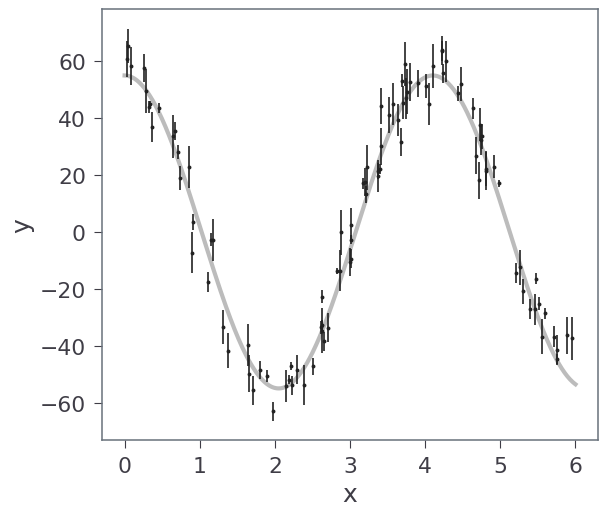

In [4]:
# data
pl.errorbar(x_, y_, yerr=yerr_, fmt=".k", capsize=0)

# true model
x0 = np.linspace(0, baseline, 500)
y0 = K_ * np.cos((2. * np.pi / P_)*x0)

pl.plot(x0, y0, "k", alpha=0.3, lw=3)
pl.xlabel("x")
pl.ylabel("y");

## Using the sampler
The sampler requires a likelihood and a prior function.

The likelihood is modeled with the residuals from the observations and the model, as well as the jitter parameter.

We will use uniform priors for every parameter.

We also need to define some limits for the prior volume, or search space:

In [5]:
limits = [[10, 100],
          [0.1, 8],
          [np.log(1), np.log(20)],]


def loglike(theta):
    model = sinusoid(theta)
    jitter = theta[-1]
    sigma2 = yerr_**2 + np.exp(2 * jitter)
    return -0.5 * np.sum((y_ - model) ** 2 / sigma2 + np.log(sigma2)) - 0.5 * np.log(2*np.pi) * N_


def logprior(theta):
    lp = 0.
    for p in range(ndim_):
        if limits[p][0] <= theta[p] <= limits[p][1]:
            lp += np.log(1 / (limits[p][1] - limits[p][0]))
        else:
            return -np.inf

    return lp

We need to choose our sampler setup and a starting position:

In [31]:
setup = [3, 15, 1000, 2]
ntemps, nwalkers, nsweeps, nsteps = setup

In [32]:
p0 = [theta_[:ndim_-1]+[np.log(theta_[-1])] + 0.1 * np.random.randn(nwalkers, ndim_) for t in range(ntemps)]

And we run the sampler:

In [33]:
sampler = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                              ntemps=ntemps,
                              adaptative=True,
                              config_adaptation_halflife=200,
                              config_adaptation_rate=0.3,
                              config_adaptation_decay=0)
    
silent = sampler.run_mcmc(p0, nsweeps, nsteps, progress=True)

100%|████████████| 2000/2000 [00:04<00:00, 466.87it/s]


We can take a look at the chains:

In [34]:
ch = sampler.get_chains(flat=True, discard=1)
ch0 = ch[0]

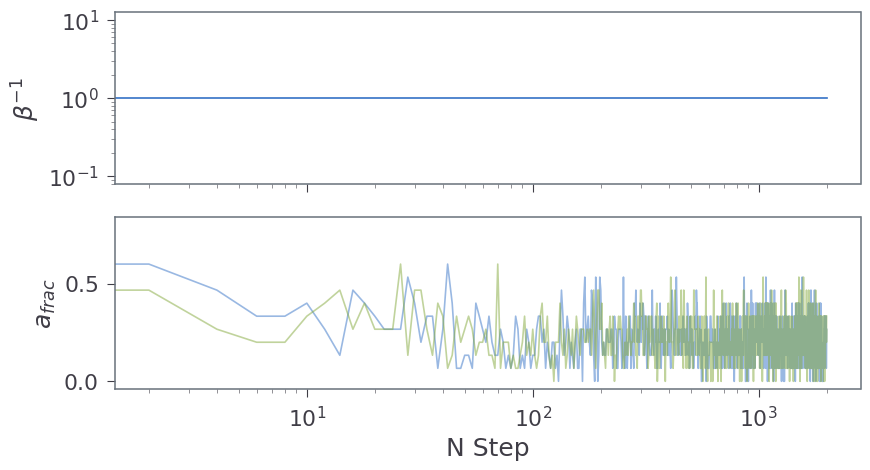

In [35]:
plot_betas_ratios(sampler, setup)

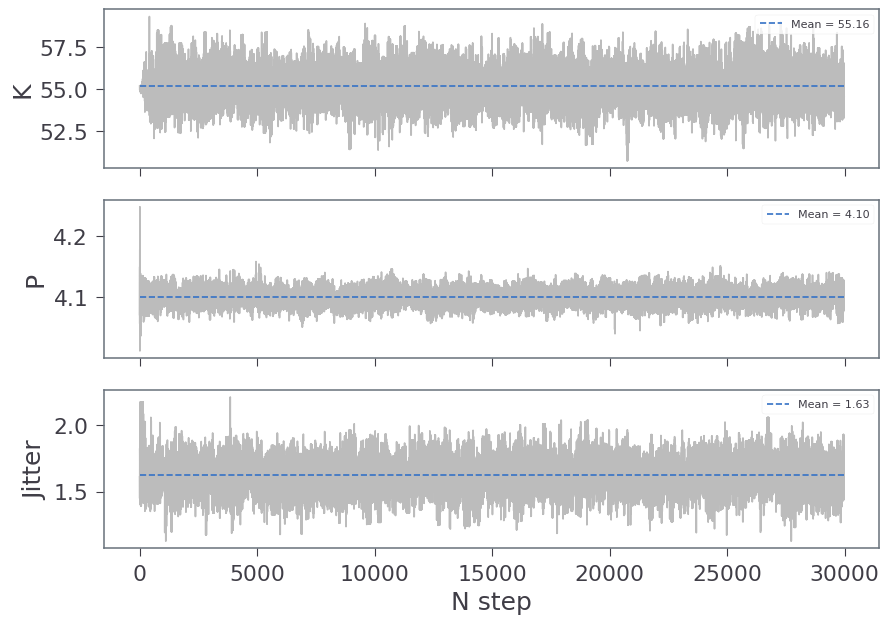

In [36]:
fig, axes = pl.subplots(ndim_, figsize=(10, 7), sharex=True)

labels = ['K', 'P', 'Jitter']

for i in range(ndim_):
    ax = axes[i]
    chain = ch[0][:, i]
    ax.plot(chain, 'k', alpha=0.3)
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.hlines(np.mean(chain), 0, len(chain), label=f'Mean = {np.mean(chain):.2f}', ls='--')
    ax.legend(loc=1, fontsize=8)
axes[-1].set_xlabel('N step');


We discard the initial samples as burn-in, select our cold chain and we *corner plot*:

In [37]:
import corner
flat_samples = sampler.get_chains(flat=True, discard=500)[0]

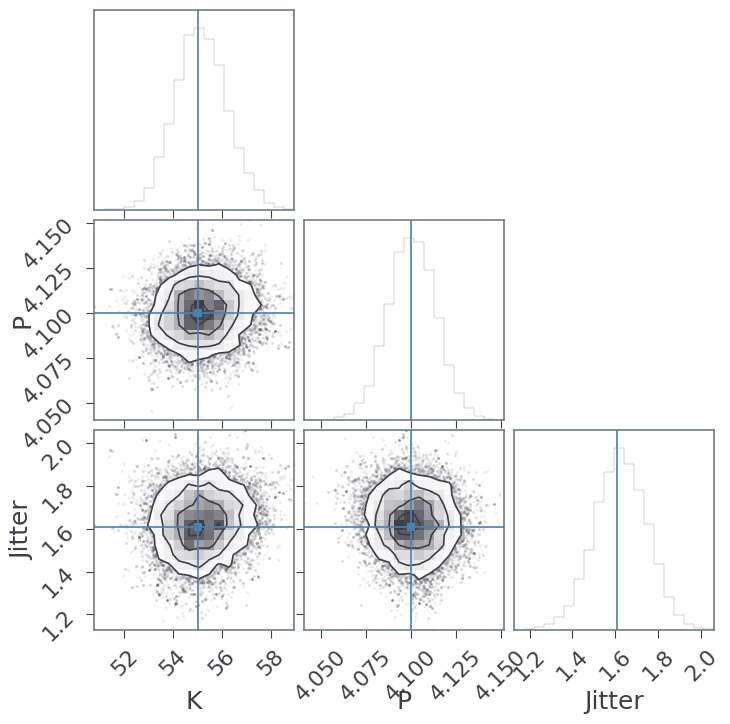

In [38]:
fig = corner.corner(flat_samples, labels=labels, truths=theta_[:ndim_-1]+[np.log(theta_[-1])])

In [39]:
for i in range(ndim_):
    res = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(res)
    display(Math(rf'{labels[i]} = {res[0]:.3f}^{{ + {q[0]:.3f} }}_{{- {q[1]:.3f} }}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [40]:
K_ = 55
P_ = 4.1
j_ = 1.609  # white noise

In [41]:
print(f'ntemps, nwalkers = {ntemps}, {nwalkers}')
print(f'Af = {np.round(sampler.get_attr("acceptance_fraction").mean(axis=1), 2)}')
print(f'Af mean = {np.round(sampler.get_attr("acceptance_fraction").mean(), 2)}')
print(f'Sr = {np.round(sampler.ratios_history.reshape((setup[2], setup[0]-1)).mean(axis=0), 2)}')
print(f'Sr mean = {np.round(sampler.ratios_history.reshape((setup[2], setup[0]-1)).mean(), 2)}')
print(f'Z = {sampler.thermodynamic_integration(discard=1000)[0]:.2f} +-{sampler.thermodynamic_integration(discard=1000)[1]:.2f}')

ntemps, nwalkers = 3, 15
Af = [0.64 0.64 0.65]
Af mean = 0.64
Sr = [0.21 0.21]
Sr mean = 0.21
Z = -342.33 +-0.89


In [15]:
def plot_betas_ratios(sampler, setup):
    bh = sampler.betas_history
    rh = sampler.ratios_history

    fig, axes = pl.subplots(2, 1, figsize=(9, 5), sharex=True)

    bh1 = bh.reshape((setup[2], setup[0]))
    rh1 = rh.reshape((setup[2], setup[0]-1))

    for i in range(setup[0]-2):
            bh_sel = bh1[:, i]
            b = 1/np.array(bh_sel)
            axes[0].plot(np.arange(setup[2])*setup[3], b)
            axes[0].set_xscale('log')
            axes[0].set_yscale('log')


    for i in np.arange(setup[0]-1):
        r = rh1[:, i]
        axes[1].plot(np.arange(setup[2])*setup[3], r, alpha=0.5)

    if True:
        axes[1].set_xlabel("N Step")
        axes[0].set_ylabel(r"$\beta^{-1}$")
        axes[1].set_ylabel(r"$a_{frac}$")

    pl.tight_layout()